![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Healthcare/15.German_Licensed_Models.ipynb)

## Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

## Legal NER

The dataset used to train this model is taken from Leitner, et.al (2019)

*Leitner, E., Rehm, G., and Moreno-Schneider, J. (2019). Fine-grained Named Entity Recognition in Legal Documents. In Maribel Acosta, et al., editors, Semantic Systems. The Power of AI and Knowledge Graphs. Proceedings of the 15th International Conference (SEMANTiCS2019), number 11702 in Lecture Notes in Computer Science, pages 272–287, Karlsruhe, Germany, 9. Springer. 10/11 September 2019.*

**Source of the annotated text:**

Court decisions from 2017 and 2018 were selected for the dataset, published online by the Federal Ministry of Justice and Consumer Protection. The documents originate from seven federal courts: Federal Labour Court (BAG), Federal Fiscal Court (BFH), Federal Court of Justice (BGH), Federal Patent Court (BPatG), Federal Social Court (BSG), Federal Constitutional Court (BVerfG) and Federal Administrative Court (BVerwG).

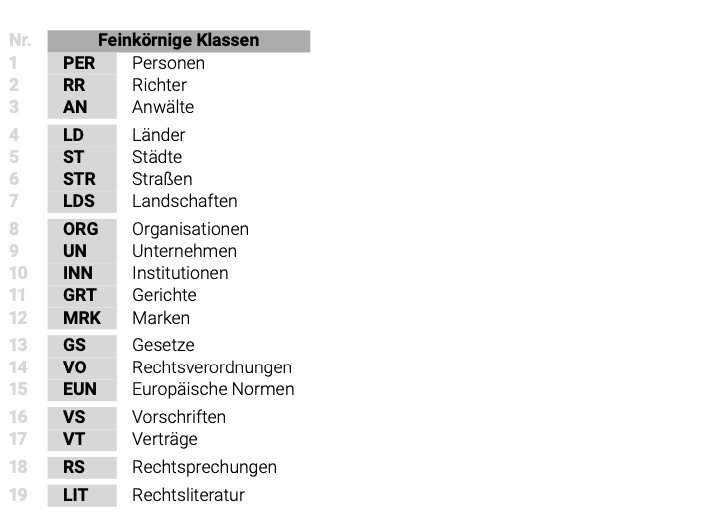

**Macro-average	 prec: 0.9210195, rec: 0.91861916, f1: 0.91981775**

**Micro-average	 prec: 0.9833763, rec: 0.9837547, f1: 0.9835655**

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\

# Tokenizer splits words in a relevant format for NLP

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = nlp.WordEmbeddingsModel.pretrained("w2v_cc_300d",'de','clinical/models')\
    .setInputCols(["sentence", 'token'])\
    .setOutputCol("embeddings")\
    .setCaseSensitive(False)

legal_ner = medical.NerModel.pretrained("ner_legal",'de','clinical/models') \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

legal_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\


legal_pred_pipeline = nlp.Pipeline(
      stages = [
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      legal_ner,
      legal_ner_converter
      ])

empty_df = spark.createDataFrame([['']]).toDF("text")

legal_pred_model = legal_pred_pipeline.fit(empty_df)

legal_light_model = nlp.LightPipeline(legal_pred_model)

w2v_cc_300d download started this may take some time.
Approximate size to download 1.2 GB
[OK!]
ner_legal download started this may take some time.
[OK!]


In [ ]:
import pandas as pd

def get_ner_df (light_model, text):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []

  for n in light_result[0]['ner_chunk']:
          
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 


  df = pd.DataFrame({'chunks':chunks, 'entities':entities})

  return df


In [ ]:
text = '''
Jedoch wird der Verkehr darin naheliegend den Namen eines der bekanntesten Flüsse Deutschlands erkennen, welcher als Seitenfluss des Rheins durch Oberfranken, Unterfranken und Südhessen fließt und bei Mainz in den Rhein mündet.
Klein , in : Maunz / Schmidt-Bleibtreu / Klein / Bethge , BVerfGG , § 19 Rn. 9
Richtlinien zur Bewertung des Grundvermögens – BewRGr – vom19. I September 1966 (BStBl I, S.890) 
 '''
df = get_ner_df (legal_light_model, text)

df

,chunks,entities
0,Deutschlands,LD
1,Rheins,LDS
2,Oberfranken,LDS
3,Unterfranken,LDS
4,Südhessen,LDS
5,Mainz,ST
6,Rhein,LDS
7,"Klein , in : Maunz / Schmidt-Bleibtreu / Klein...",LIT
8,Richtlinien zur Bewertung des Grundvermögens –...,VS
9,"I September 1966 (BStBl I, S.890)",VS


## German Public NER

In [ ]:
public_pipeline = nlp.PretrainedPipeline('entity_recognizer_lg','de')

entity_recognizer_lg download started this may take some time.
Approx size to download 2.3 GB
[OK!]


In [ ]:
text = """William Henry Gates III (* 28. Oktober 1955 in London) ist ein US-amerikanischer Geschäftsmann, Softwareentwickler, Investor und Philanthrop.
Er ist bekannt als Mitbegründer der Microsoft Corporation. Während seiner Karriere bei Microsoft war Gates Vorsitzender, Chief Executive Officer (CEO),
Präsident und Chief Software Architect und bis Mai 2014 der größte Einzelaktionär. Er ist einer der bekanntesten Unternehmer und Pioniere 
der Mikrocomputer-Revolution der 1970er und 1980er Jahre. Gates wurde in Seattle, Washington, geboren und wuchs dort auf. 
1975 gründete er Microsoft zusammen mit seinem Freund aus Kindertagen, Paul Allen, in Albuquerque, New Mexico. Es entwickelte sich zum weltweit größten
Unternehmen für Personal-Computer-Software. Gates leitete das Unternehmen als Chairman und CEO, bis er im Januar 2000 als CEO zurücktrat. 
Er blieb jedoch Chairman und wurde Chief Software Architect. In den späten neunziger Jahren wurde Gates für seine Geschäftstaktiken kritisiert,
die als wettbewerbswidrig angesehen wurden. Diese Meinung wurde durch zahlreiche Gerichtsurteile bestätigt. Im Juni 2006 gab Gates bekannt, 
dass er eine Teilzeitstelle bei Microsoft und eine Vollzeitstelle bei der Bill & Melinda Gates Foundation, der privaten gemeinnützigen Stiftung, 
die er und seine Frau Melinda Gates im Jahr 2000 gegründet haben, übernehmen wird. [ 9] Er übertrug seine Aufgaben nach und nach auf Ray Ozzie und Craig Mundie.
Im Februar 2014 trat er als Vorsitzender von Microsoft zurück und übernahm eine neue Position als Technologieberater, um den neu ernannten
CEO Satya Nadella zu unterstützen.Die Mona Lisa ist ein Ölgemälde aus dem 16. Jahrhundert, das von Leonardo geschaffen wurde. Es findet im Louvre in Paris statt."""

result = public_pipeline.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n in result['entities']:
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities})

df

,chunks,entities
0,William Henry Gates III,PER
1,London),LOC
2,US-amerikanischer,MISC
3,Microsoft Corporation.,ORG
4,Microsoft,ORG
5,Gates,ORG
6,"(CEO),",MISC
7,Chief Software Architect,MISC
8,Mikrocomputer-Revolution,MISC
9,Jahre.,PER


## Highlight Entities

In [ ]:
text = '''
Jedoch wird der Verkehr darin naheliegend den Namen eines der bekanntesten Flüsse Deutschlands erkennen,
 welcher als Seitenfluss des Rheins durch Oberfranken, Unterfranken und Südhessen fließt und bei Mainz in den Rhein mündet.
Klein , in : Maunz / Schmidt-Bleibtreu / Klein / Bethge , BVerfGG , § 19 Rn. 
Richtlinien zur Bewertung des Grundvermögens – BewRGr – vom19. I September 1966 (BStBl I, S.890) 
 '''

ann_text = legal_light_model.fullAnnotate(text)

In [ ]:
visualiser = nlp.viz.NerVisualizer()

visualiser.display(ann_text[0], label_col='ner_chunk', document_col='document')

## German Traffic NER

In [ ]:
text_bau_arbeiten = '''Die A7 wird für mehrere Wochen auf einem Teilstück in und um Kassel gesperrt. 
Autofahrer müssen mit Staus rechnen. Das A7 Autobahnkreuz Kassel-Mitte bei Kassel wird verengt.
Die Abfahrt von der A7 auf die A49 aus Richtung Norden gesperrt.
Die Sperrung soll mehrere Wochen dauern -Grund dafür ist eine Baustelle.
Update vom Donnerstag, 17.09.2020, 11.10 Uhr:  Die LED-Wegweiser werden angeschaltet, 
die ersten Autos werden umgeleitet und die Bauarbeiten werden in Kürze beginnen. 
In der Nacht zu Freitag (18.09.2020) wird es auf der Autobahn A7 bei Kassel eng.
Die Abfahrt von der A7 zur A49 in Fahrtrichtung Norden wird dann in der Nacht zu Samstag (19.09.2020) 
komplett gesperrt.Der Abschnitt wird laut Hessen Mobil von rund 90.000 Fahrzeugen pro Tag befahren.
Darunter sind alleine rund 17.000 Lkw. Das Straßen- und Verkehrsmanagement des Landes Hessen, 
weist darauf hin das sich zu den Stoßzeiten Verkehrsbehinderungen nicht vermeiden lassen.
Erstmeldung vom Montag, 09.09.2020, 11.50Uhr:  Die kommenden Wochen werden für Verkehrsteilnehmer in und 
um Kassel zur Belastungsprobe. Ab Donnerstag (17.09.2020) wird der Asphalt auf der A7 zwischen den Anschlussstellen 
Kassel-Nord und dem Autobahnkreuz Kassel-Mitte eingebaut. Hessen Mobil muss die Fahrbahn Richtung Süden auf
diesem Teilstück für etwa vier Wochen sperren. Schon jetzt ist klar:
Es wird erhebliche Beeinträchtigungen geben und zu vielen Staus auf den Umleitungsstrecken kommen.'''


text_unfall = '''Am 09.10.2020, gegen 16.30 h, kam es zu einem schweren Verkehrsunfall in Langenfeld an der 
Einmündung Immigrather Straße, Bahnstraße. Eine 50-jährige Langenfelderin befuhr mit ihrem PKW Volkswagen die 
Immigrather Straße in Richtung Bahnstraße. Aus bislang noch ungeklärter Ursache übersah sie an der Einmündung den 
PKW Opel eines 19-jährigen Hildeners der aus ihrer Sicht von links kam und stieß mit ihm zusammen.
Durch die Wucht des Aufpralls wurde der Opel gegen ein auf der Mittelinsel befindlichen Baum und gegen eine 
Warnbake geschleudert. Das Fahrzeug überschlug sich und blieb auf dem Dach liegen. Die Unfallbeteiligten 
wurden bei dem Unfall schwer verletzt und mussten mittels Rettungswagen in ein Krankenhaus verbracht werden. 
Beide PKW waren nicht mehr fahrbereit und wurden abgeschleppt. Es entstand hoher Sachschaden an den Fahrzeugen 
und Verkehrseinrichtungen. Der Einmündungsbereich musste für die Dauer der Unfallaufnahme komplett gesperrt werden.'''



In [ ]:
# Traffic NER Pipeline

de_ner_traffic = medical.NerModel.pretrained("ner_traffic",'de','clinical/models') \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner_traffic") 

de_ner_traffic_converter = medical.NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner_traffic"]) \
  .setOutputCol("ner_chunk")


traffic_pred_pipeline = nlp.Pipeline(
      stages = [
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      de_ner_traffic,
      de_ner_traffic_converter
      ])

empty_df = spark.createDataFrame([['']]).toDF("text")

traffic_pred_model = traffic_pred_pipeline.fit(empty_df)

traffic_light_model = nlp.LightPipeline(traffic_pred_model)

ner_traffic download started this may take some time.
[OK!]


In [ ]:
light_traffic_result = traffic_light_model.fullAnnotate(text_bau_arbeiten)

chunks = []
entities = []

for n in light_traffic_result[0]['ner_chunk']:
        
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
    
df = pd.DataFrame({'chunks':chunks, 'entities':entities})

df.sample(20)

,chunks,entities
27,"Montag, 09.09.2020",DATE
36,Hessen Mobil,ORGANIZATION_COMPANY
9,gesperrt,TRIGGER
18,A49,LOCATION_STREET
13,Freitag,DATE
20,Samstag,DATE
14,18.09.2020,DATE
34,Anschlussstellen \nKassel-Nord,LOCATION
6,A7,LOCATION_STREET
3,A7,LOCATION_STREET


In [ ]:
ann_text = traffic_light_model.fullAnnotate(text_bau_arbeiten)

visualiser.display(ann_text[0], label_col='ner_chunk', document_col='document')

In [ ]:
ann_text = traffic_light_model.fullAnnotate(text_unfall)

visualiser.display(ann_text[0], label_col='ner_chunk', document_col='document')